<a href="https://colab.research.google.com/github/M-Salim-I/Other-Projects/blob/main/MLEndVoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The mini-project consists of two components:


1.   **Basic solution**: Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.
2.   **Advanced solution** : There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model (e.g. identify a numeral in a short sequence). (ii) Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).  

The submission will consist of a single Jupyter notebook for both basic and advanced solution. The uploaded notebook should contain: 

*   **Text cells**, describing concisely each step and results.
*   **Code cells**, implementing each step.
*   **Output cells**, i.e. the output from each code cell.

and should have **two separate sections** for the basic and the advanced solutions.

What should you include in your notebook?

*   Title, student name, student ID.
*   Brief summary.
*   Dataset preparation.
*   Dataset visualisation.
*   Preprocessing.
*   Model(s) description.
*   Training and validation tasks.
*   Performance evaluation (accuracy, confusion matrix, ROC curve, etc).
*   Conclusions.


How will we evaluate your submission?

*   Conciseness in your writing (10%).
*   Correctness in your methodology (30%).
*   Correctness in your analysis and conclusions (30%).
*   Completeness (10%).
*   Originality (10%).
*   Efforts to try something new (10%).

Suggestion: Why don't you use **GitHub** to manage your project? GitHub can be used as a presentation card that showcases what you have done and gives evidence of your data science skills, knowledge and experience. 


# Title: MLEnd miniproject
### Student Name: Mohammed Salim Ibrahim
### Student ID: 170050601


# Modules/Libraries used

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, re, pickle, glob
import urllib.request
import zipfile
from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic solution [6 marks]:



**Problem Statement:** Predicting the intonation of a short audio segment.

## Breif summary:

In this notebook, we will use the MLEnd data set. Firstly, we preprocess the data and then build a model that predicts the intonation of a short audio segment. Next, we will evaluate the performance of our model and come to a conclusion of what we have done.
Note: this is a multi-class classification problem

The MLEnd dataset contains audio files where each audio file contains a single digit and the intonation that is associated with it. For example, such an audio file will be a voice saying the digit number "0" with the intonation of the voice being excited.

## Dataset preparation and exploration

The following code cells below with their explanations are referenced here:
https://qmplus.qmul.ac.uk/mod/resource/view.php?id=1566660

Here we see how many audio files we have in our data set:

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

This figure (20,000) corresponds to the number of **items** or **samples** in our dataset.

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions.

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal. Moreover, we  define a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

**Note: The cell below is commented out, this is done to avoid downloading all the files again repeatedly when re-running the notebook.**

In [ ]:
'''
def getPitch(x,fs,winLen=0.02): 
  p = winLen*fs
  frame_length = int(2 ** int(p - 1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y = x, fmin = 80, fmax = 450, sr = fs, frame_length=frame_length, hop_length=hop_length)
  return f0,voiced_flag

def getXy(files,labels_file,scale_audio = False):
  X, y1, y2 =[], [], []
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    digitlabels = list(labels_file[labels_file['File ID'] == fileID]['digit_label'])[0]
    intonations = list(labels_file[labels_file['File ID'] == fileID]['intonation'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x, fs, winLen = 0.02)
    # how the fetures are defined
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0)) < 1 else 0
    voiced_fr = np.mean(voiced_flag)
    # the dataset X is built/priortises on these features
    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y1.append(digitlabels)
    y2.append(intonations)
  return np.array(X), np.array(y1), np.array(y2)

X, y1, y2 = getXy(files, labels_file = labels, scale_audio = True) # all of the dataset
df = pd.DataFrame({'power': X[:, 0], 'pitch_mean': X[:, 1], 'pitch_standard_deviation': X[:, 2], 'fraction_of_voiced_region': X[:, 3], 
                   'number': y1, "intonation": y2})
# These 3 lines of code should be outputted in 3 separate code blocks
cd /content/drive/My Drive
!pwd
df.to_csv("complete_data.csv", index = False)
'''

'\ndef getPitch(x,fs,winLen=0.02): \n  p = winLen*fs\n  frame_length = int(2 ** int(p - 1).bit_length())\n  hop_length = frame_length//2\n  f0, voiced_flag, voiced_probs = librosa.pyin(y = x, fmin = 80, fmax = 450, sr = fs, frame_length=frame_length, hop_length=hop_length)\n  return f0,voiced_flag\n\ndef getXy(files,labels_file,scale_audio = False):\n  X, y1, y2 =[], [], []\n  for file in tqdm(files):\n    fileID = file.split(\'/\')[-1]\n    digitlabels = list(labels_file[labels_file[\'File ID\'] == fileID][\'digit_label\'])[0]\n    intonations = list(labels_file[labels_file[\'File ID\'] == fileID][\'intonation\'])[0]\n    fs = None # if None, fs would be 22050\n    x, fs = librosa.load(file,sr=fs)\n    if scale_audio: x = x/np.max(np.abs(x))\n    f0, voiced_flag = getPitch(x, fs, winLen = 0.02)\n    # how the fetures are defined\n    power = np.sum(x**2)/len(x)\n    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0\n    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))

From the cell above we apply the function `getXy` to extract all the audio files in our data set. Then we create a pandas data frame and turn it into a CSV (comma-separated values) file. Next, we save the CSV file to our drive so we can use the completed data for future purposes.

Here we load our created CSV file and look at the first 5 rows of our data frame.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/complete_data.csv")
df.head()

,power,pitch_mean,pitch_standard_deviation,fraction_of_voiced_region,number,intonation
0,0.017455,227.662371,32.420767,0.386792,12,bored
1,0.038618,187.723934,62.598813,0.291139,1,question
2,0.042435,128.812251,20.912529,0.313953,40,excited
3,0.006295,130.283099,5.193614,0.241176,9,excited
4,0.017070,171.916609,26.854425,0.111888,6,question


Here we check to see if there are any missing values in our data set and observe that there are no missing values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   power                      20000 non-null  float64
 1   pitch_mean                 20000 non-null  float64
 2   pitch_standard_deviation   20000 non-null  float64
 3   fraction_of_voiced_region  20000 non-null  float64
 4   number                     20000 non-null  int64  
 5   intonation                 20000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 937.6+ KB


We now check to see if there is any class imbalance in our data set for the "intonation" column. We do this through a bar plot (i.e. a count plot in seaborn) and count the number of files that represent each intonation.

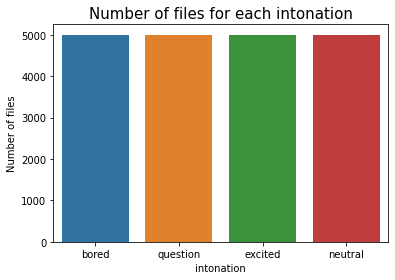

In [ ]:
#plotting the graph
g = sns.countplot(df.intonation)
g.set_title("Number of files for each intonation", fontsize = 15)
g.set_ylabel("Number of files");

We can see that from our data set the class labels for "intonation" are balanced, therefore we leave the data set as is for the basic solution.

Before splitting our dataset into training and validation data sets, we will make a copy of our data frame and apply a label encoder to each intonation.

In [ ]:
df_encoded = df.copy(deep = True)
le = LabelEncoder()
df_encoded["intonation_enc"] = le.fit_transform(df_encoded["intonation"])
df_encoded.head()

,power,pitch_mean,pitch_standard_deviation,fraction_of_voiced_region,number,intonation,intonation_enc
0,0.017455,227.662371,32.420767,0.386792,12,bored,0
1,0.038618,187.723934,62.598813,0.291139,1,question,3
2,0.042435,128.812251,20.912529,0.313953,40,excited,1
3,0.006295,130.283099,5.193614,0.241176,9,excited,1
4,0.017070,171.916609,26.854425,0.111888,6,question,3


We find out which intonation represents which number in the intonation_enc column.

In [ ]:
le.inverse_transform([0, 1, 2, 3])

array(['bored', 'excited', 'neutral', 'question'], dtype=object)

We can see that since there are 4 intonations our labels will be 0, 1, 2, 3, representing the following intonations: "bored", "excited", "neutral", "question" respectively.

## Model

We split the data set randomly such that the validation data set accounts for 30% of the total number of samples in the data set. Since there are 4 predictors it will be hard to visualize them all at once. However, we will be able to evaluate the performance of a classification model through a confusion matrix.

In [ ]:
# random state in order for reproducible results
# 70:30 split for our dataset
X_train, X_val, y_train, y_val = train_test_split(df_encoded.loc[:, : "fraction_of_voiced_region"].values, df_encoded.intonation_enc.values, 
                                                  random_state = 123, test_size = 0.3)
# re-scaling each of our 4 features
scaling = StandardScaler()
X_train, X_val= scaling.fit_transform(X_train), scaling.fit_transform(X_val)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(14000, 4) (14000,) (6000, 4) (6000,)


After the partition of the data set, we then scale down each of the 4 features down to a standard normal distribution. This technique will be used since we will be implementing models that are sensitive to feature scaling such as Logistic Regression and K-Nearest Neighbours (Knn). Although the feature scaling technique of standardization is useful for some models, models such as Tree-based algorithms that we will use are invariant to the scale of the features. Hence the performance for some models will improve whilst others will not change at all.

To compare different models on our data set and see which model performs the best, we will use **Random Search** with some of the hyperparameters that are used for each model.

**Note:** In the labs, we have applied cross-validation on the whole of our data set as this automatically splits our data set into training and validation data sets. However, we have already partitioned our data set, therefore we will be applying cross-validation on `X_train` which will also allow us to compare the accuracy scores between models.

**Description of the model:**
* The models we will be comparing are Knn, Logistic regression and the random forest classifier.
* We will be using the 4 features that we have extracted from our data set and feed those into each of our models.
* The set of hyperparameters chosen for each model are chosen at random.
* The accuracy score for each of our models will be compared in order to choose the best model.

Reference of implementation for the code cell below: 
https://github.com/krishnaik06/Pipelines-Using-Sklearn/blob/master/SklearnPipeline.ipynb





In [ ]:
# Create a pipeline
pipe = Pipeline([("clf", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
random_param = [
                {"clf": [KNeighborsClassifier()],
                 "clf__n_neighbors": [5, 10, 25, 50, 100]
                 },
                {"clf": [LogisticRegression()],
                 "clf__penalty": ['l2'],
                 "clf__C": np.logspace(0, 4, 10),
                 "clf__solver": ['saga','sag'], # These solvers don't allow L1 penalty
                 "clf__random_state": [123] #  As solver == ‘sag’, ‘saga’ 
                 },
                {"clf": [RandomForestClassifier()],
                 "clf__n_estimators": [10, 100, 1000],
                 "clf__max_depth": [5, 10, 15, 25, 30, None],
                 "clf__min_samples_leaf": [1 ,2, 5, 10, 15, 100],
                 "clf__max_leaf_nodes": [2, 5, 10, None],
                 "clf__random_state": [123]}
              ]
# create a randomsearch of the pipeline, then fit the best model
# n_jobs = -1 means using all processors
# verbose = 0 Controls the verbosity: the higher, the more messages
# computing the scores on the training set can be computationally expensive and is not strictly required to select the parameters that yield the best generalization performance.
# cv > 5 takes considerably longer time
randomsearch = RandomizedSearchCV(pipe, random_param, n_iter = 10, cv = 7, 
                                  verbose = 0, n_jobs = -1, random_state = 123) # Fit random search
best_model = randomsearch.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the best model is:", best_model.score(X_val, y_val) * 100, "%")

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)
The mean accuracy of the best model is: 56.39999999999999 %


From the results of our random search, we can see the best model is the random forest classifier with a 56.4% mean accuracy score (on the validation data set) stated above in the output cell.

We now assess how well our best classifier deals with each class separately which we will depict in a confusion matrix below.

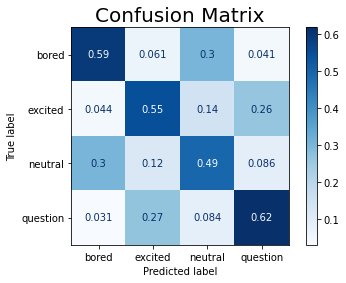

In [ ]:
best_rand_model = best_model.best_estimator_
plot_confusion_matrix(best_rand_model, X_val, y_val, display_labels = le.inverse_transform([0, 1, 2, 3]),
                                 cmap = plt.cm.Blues, normalize = 'true')
plt.title("Confusion Matrix", fontsize = 20);

Here we can see our random forest classifier predicts each intonation 
somewhat moderately okay with the intonation "question" being predicted correctly most of the time over the others (i.e. out of all of the audio samples that are labelled as "question" the model predicts only 62% of them correctly as "question").

We will now produce a classification report.

In [ ]:
print(classification_report(y_val, best_rand_model.predict(X_val), target_names = le.inverse_transform([0, 1, 2, 3])))

              precision    recall  f1-score   support

       bored       0.61      0.59      0.60      1497
     excited       0.55      0.55      0.55      1497
     neutral       0.48      0.49      0.49      1477
    question       0.62      0.62      0.62      1529

    accuracy                           0.56      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.57      0.56      0.56      6000



From the classification report, the values in the recall column for each intonation are the same values as those in the diagonal entries in the confusion matrix. Moreover, the precision values are quite high for "bored" and "question" compared to other intonations.

## Conclusion

To conclude, the accuracy score (56.4%)that we obtained for our best model (random forest classifer) was moderately okay but could have been improved. For future work, in order to get a better accuracy score, we could have extracted more features from the audio files instead of extracting only 4. Due to time constraints we could also have used grid search (even though it is more computationally expensive than random search) instead of random search so that we could have obtained the best hyperparameters for our best model. In addition, we could have also increased the number of K-folds when carrying out cross-validation (which also is more computationally expensive). Finally, we could have also considered algorithms such as SVM (support vector machine) and Naive Bayes classifier as well as using techniques such as gradient boosting to improve the performance of the random forest classifier.

# 2.  **Advanced solution** [10 marks]:

**Problem Statement:** Identifying a numeral that is and isn't divisible by 5 in a short audio segment.

## Brief summary:

In this notebook we will use the MLEnd datset. Firstly, we prepocess the data and then build a model that predicts whether a numeral is divisible by 5 or not based on a short audio segment. Next, we will evaluate the preformance of our model and come to a conclusion of what we have done.

**Note:** This is a binary classification problem.

The MLEnd dataset contains audio files where each audio file contains a single digit and the intonation that is asscociated with it. For example, such an audio will be a voice saying the digit number 0 with the intonation of the voice being excited.

## Dataset preparation

The following code cells below with their explanations are referenced here:
https://qmplus.qmul.ac.uk/mod/resource/view.php?id=1566660

Here we see how many audio files we have in our data set:

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

This figure (20k) corresponds to the number of **items** or **samples** in our dataset.

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions.

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal. Moreover, we  define a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

**Note: The cell below is commented out, this is done to avoid downloading all the files again repeatedly when re-running the notebook.**

In [ ]:
'''
def getPitch(x,fs,winLen=0.02): 
  p = winLen*fs
  frame_length = int(2 ** int(p - 1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y = x, fmin = 80, fmax = 450, sr = fs, frame_length=frame_length, hop_length=hop_length)
  return f0,voiced_flag

def getXy(files,labels_file,scale_audio = False):
  X, y1, y2 =[], [], []
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    digitlabels = list(labels_file[labels_file['File ID'] == fileID]['digit_label'])[0]
    intonations = list(labels_file[labels_file['File ID'] == fileID]['intonation'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x, fs, winLen = 0.02)
    # how the fetures are defined
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0)) < 1 else 0
    voiced_fr = np.mean(voiced_flag)
    # the dataset X is built/priortises on these features
    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y1.append(digitlabels)
    y2.append(intonations)
  return np.array(X), np.array(y1), np.array(y2)

X, y1, y2 = getXy(files, labels_file = labels, scale_audio = True) # all of the dataset
df = pd.DataFrame({'power': X[:, 0], 'pitch_mean': X[:, 1], 'pitch_standard_deviation': X[:, 2], 'fraction_of_voiced_region': X[:, 3], 
                   'number': y1, "intonation": y2})
# These 3 lines of code should be outputted in 3 separate code blocks
cd /content/drive/My Drive
!pwd
df.to_csv("complete_data.csv", index = False)
'''

'\ndef getPitch(x,fs,winLen=0.02): \n  p = winLen*fs\n  frame_length = int(2 ** int(p - 1).bit_length())\n  hop_length = frame_length//2\n  f0, voiced_flag, voiced_probs = librosa.pyin(y = x, fmin = 80, fmax = 450, sr = fs, frame_length=frame_length, hop_length=hop_length)\n  return f0,voiced_flag\n\ndef getXy(files,labels_file,scale_audio = False):\n  X, y1, y2 =[], [], []\n  for file in tqdm(files):\n    fileID = file.split(\'/\')[-1]\n    digitlabels = list(labels_file[labels_file[\'File ID\'] == fileID][\'digit_label\'])[0]\n    intonations = list(labels_file[labels_file[\'File ID\'] == fileID][\'intonation\'])[0]\n    fs = None # if None, fs would be 22050\n    x, fs = librosa.load(file,sr=fs)\n    if scale_audio: x = x/np.max(np.abs(x))\n    f0, voiced_flag = getPitch(x, fs, winLen = 0.02)\n    # how the fetures are defined\n    power = np.sum(x**2)/len(x)\n    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0\n    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))

From the cell above we apply the function `getXy` to extract **all** the audio files in our data set. Then we create a pandas data frame and turn it into a CSV (comma separated values) file. Next, we save the CSV file to our drive so we can use the completed data for future purposes.

Here we load our created CSV file and look at the first 5 rows of our dataframe.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/complete_data.csv")
df.head()

,power,pitch_mean,pitch_standard_deviation,fraction_of_voiced_region,number,intonation
0,0.017455,227.662371,32.420767,0.386792,12,bored
1,0.038618,187.723934,62.598813,0.291139,1,question
2,0.042435,128.812251,20.912529,0.313953,40,excited
3,0.006295,130.283099,5.193614,0.241176,9,excited
4,0.017070,171.916609,26.854425,0.111888,6,question


Here we check to see if there are any missing values in our data set and observe that there are no missing values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   power                      20000 non-null  float64
 1   pitch_mean                 20000 non-null  float64
 2   pitch_standard_deviation   20000 non-null  float64
 3   fraction_of_voiced_region  20000 non-null  float64
 4   number                     20000 non-null  int64  
 5   intonation                 20000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 937.6+ KB


We now find out how many unique digits there are in our data set as well as how many digits are divisible by 5 and how many of those are not divisible 5.

In [ ]:
len(df.number.unique()), len(df[df.number % 5 == 0].number.unique()), len(df[df.number % 5 != 0].number.unique())

(32, 16, 16)

We can see that we have in total 32 unique digits in our data set with half of the digits that are divisible by 5 and half of the digits that are not divisible by 5.

We now make a copy of our data set and derive a new column called "divBy5" such that it has a value of "yes" if a sample is divisible by 5 and a label of "no" if a sample is not divisible by 5.

In [ ]:
df5 = df.copy(deep = True)
div5, notdiv5  = (df5.number % 5 == 0), (df5.number % 5 != 0)
conditions, choices = [div5, notdiv5], ["yes", "no"]
df5["divBy5"] = np.select(conditions, choices, default = "")
df5.head()

,power,pitch_mean,pitch_standard_deviation,fraction_of_voiced_region,number,intonation,divBy5
0,0.017455,227.662371,32.420767,0.386792,12,bored,no
1,0.038618,187.723934,62.598813,0.291139,1,question,no
2,0.042435,128.812251,20.912529,0.313953,40,excited,yes
3,0.006295,130.283099,5.193614,0.241176,9,excited,no
4,0.017070,171.916609,26.854425,0.111888,6,question,no


We now check to see if there is any class imbalance in our data set for the "intonation" column. We do this through a bar plot (i.e. a count plot in seaborn) and count the number of files that are and aren't divisible by 5.

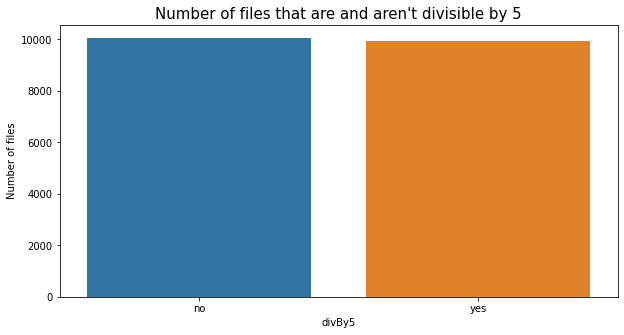

In [ ]:
#plotting the graph
plt.figure(figsize = (10, 5))
g = sns.countplot(df5.divBy5)
g.set_title("Number of files that are and aren't divisible by 5", fontsize = 15)
g.set_ylabel("Number of files");

We can see that there is a slight class imbalance (in the "divBy5" column) in our data set. We now compute the ratio of this class imbalance. (i.e. the total number of audio files that contain a digit that is divisible by 5 divided by the total number of audio files that contain a digit that isn't divisible by 5)

In [ ]:
df[df.number % 5 == 0].shape[0] / df[df.number % 5 != 0].shape[0]

0.9890601690701144

We can see that the class imbalance is not severe and that there is approxiamtely a 1:1 relationship between every audio file that contains a digit that is divisible by 5 and one that isn't.

Before splitting our dataset into training and validation, we will first apply a label encoder to the "divBy5" column.

In [ ]:
le = LabelEncoder()
df5["enc"] = le.fit_transform(df5.divBy5)
df5.head()

,power,pitch_mean,pitch_standard_deviation,fraction_of_voiced_region,number,intonation,divBy5,enc
0,0.017455,227.662371,32.420767,0.386792,12,bored,no,0
1,0.038618,187.723934,62.598813,0.291139,1,question,no,0
2,0.042435,128.812251,20.912529,0.313953,40,excited,yes,1
3,0.006295,130.283099,5.193614,0.241176,9,excited,no,0
4,0.017070,171.916609,26.854425,0.111888,6,question,no,0


We now find out which of the labels "no" and "yes" represent which number.

In [ ]:
le.inverse_transform([0, 1])

array(['no', 'yes'], dtype=object)

From here we can see that our labels of 0 and 1 represent "no" and "yes" respectively.

## Model

We split the data set randomly such that the validation data set accounts for 30% of the total number of samples in the data set. Since there are 4 predictors it will be hard to visualize them all at once. However, we will be able to evaluate the performance of a classification model through a confusion matrix and an ROC (receiver operating characteristic curve) curve.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df5.loc[:, : "fraction_of_voiced_region"].values, df5.enc.values, 
                                                  random_state = 123, test_size = 0.3)
# re-scaling each of our 4 features
scaling = StandardScaler()
X_train, X_val= scaling.fit_transform(X_train), scaling.fit_transform(X_val)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(14000, 4) (14000,) (6000, 4) (6000,)


After the partition of the data set, we then scale down each of the 4 features down to a standard normal distribution. This technique will be used since we will be implementing models that are sensitive to feature scaling such as Logistic Regression and K-Nearest Neighbours. Although the feature scaling technique of standardization is useful for some models, models such as Tree-based algorithms that we will use are invariant to the scale of the features. Hence the performance for some models will improve whilst others will not change at all.

However, we will also be constructing a neural network therefore we must apply the technique of one-hot encoding in order to use the categorical cross-entropy loss for our model.

In [ ]:
X_train, X_val, y_train_1hot, y_val_1hot = train_test_split(df5.loc[:, : "fraction_of_voiced_region"].values, pd.get_dummies(df5.divBy5).values, 
                                                  random_state = 123, test_size = 0.3)
# re-scaling each of our 4 features
scaling = StandardScaler()
X_train, X_val= scaling.fit_transform(X_train), scaling.fit_transform(X_val)
print(X_train.shape, y_train_1hot.shape, X_val.shape, y_val_1hot.shape)

(14000, 4) (14000, 2) (6000, 4) (6000, 2)


We now create a class in order to stop our neural network from training after it reaches a certain validation accuracy.

**Note: I have trained the model previously with different hyperparameters and it turns out the best validation accuracy score lies between 0.45 and 0.56**

Reference of the implemnetation of the code cell below: https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('val_accuracy') >= 0.55:
            self.model.stop_training = True

callback = CustomCallback()

We now construct our neural network and train it using the training data set, we will output the loss, training accuracy, validation loss and validation accuracy after every epoch.

Description of the Neural Network's architecture:

**Input Layer:** 
* 4 features were extracted from our data set which we will be using to feed into the network.

**Hidden Layers:**
* The dimensions for the hidden layers are chosen at random.

**Output Layer:**
* The neural network will predict whether a given sample is divisible by 5 or not therefore the nerual network's output will only be 2 features.

**Activation & Loss functions:** 
* The softmax function will allow us to understand which class the neural network is predicting in terms of probabilities.
* The categorical cross-entropy is used due to the fact that we have one-hot encoded our "divBy5" column.

Reference of the implementation of the code cell below: 
https://github.com/krishnaik06/Audio-Classification/blob/main/Part%202-%20Audio%20Classification%20Data%20Preprocessing%20And%20Model%20Creation.ipynb

In [ ]:
model = Sequential()
###first layer
model.add(Dense(128, input_shape=(4,), activation = 'relu'))
model.add(Dense(256, activation='relu'))

###second layer
model.add(Dense(256, activation = 'relu'))

###third layer
model.add(Dense(256, activation = 'relu'))

###final layer
model.add(Dense(2, activation = 'softmax'))

opt = Adam(learning_rate = 1e-3)
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = opt)

num_epochs = 100
num_batch_size = 256

start = datetime.now()

model.fit(X_train, y_train_1hot, batch_size = num_batch_size, epochs = num_epochs, validation_data = (X_val, y_val_1hot), verbose = 1, callbacks = [callback])

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
55/55 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5252 - val_loss: 0.6899 - val_accuracy: 0.5428
Epoch 2/100
55/55 [==============================] - 1s 13ms/step - loss: 0.6887 - accuracy: 0.5400 - val_loss: 0.6881 - val_accuracy: 0.5447
Epoch 3/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6870 - accuracy: 0.5454 - val_loss: 0.6879 - val_accuracy: 0.5427
Epoch 4/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6855 - accuracy: 0.5468 - val_loss: 0.6878 - val_accuracy: 0.5327
Epoch 5/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6845 - accuracy: 0.5467 - val_loss: 0.6879 - val_accuracy: 0.5470
Epoch 6/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6845 - accuracy: 0.5539 - val_loss: 0.6895 - val_accuracy: 0.5435
Epoch 7/100
55/55 [==============================] - 1s 11ms/step - loss: 0.6850 - accuracy: 0.5472 - val_loss: 0.6875 - val_accuracy: 0.5480
Epoch 

From our neural network, we have a 55.4% (approximately) validation accuracy.

To compare different models on our data set and see which model performs the best, we will use **Random Search** with some of the hyperparameters that are used for each model.

**Note:** In the labs, we have applied cross-validation on the whole of our data set as this automatically splits our data set into training and validation data sets. However, we have already partitioned our data set, therefore we will be applying cross-validation on `X_train` which will also allow us to compare the accuracy scores between models.

**Description of the model:**
* The models we will be comparing are Knn, Logistic regression and the random forest classifier
* We will be using the 4 features that we have extracted from our data set and feed those into each of our models.
* The set of hyperparameters chosen for each model are chosen at random.
* The accuracy score for each of our models will be compared in order to choose the best model.

Reference of implementation for the code cell below: 
https://github.com/krishnaik06/Pipelines-Using-Sklearn/blob/master/SklearnPipeline.ipynb

In [ ]:
# Create a pipeline
pipe = Pipeline([("clf", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
random_param = [
                {"clf": [KNeighborsClassifier()],
                 "clf__n_neighbors": [5, 10, 25, 50, 100]
                 },
                {"clf": [LogisticRegression()],
                 "clf__penalty": ['l2'],
                 "clf__C": np.logspace(0, 4, 10),
                 "clf__solver": ['saga','sag'], # These solvers don't allow L1 penalty
                 "clf__random_state": [123] #  As solver == ‘sag’, ‘saga’ 
                 },
                {"clf": [RandomForestClassifier()],
                 "clf__n_estimators": [10, 100, 1000],
                 "clf__max_depth": [5, 10, 15, 25, 30, None],
                 "clf__min_samples_leaf": [1 ,2, 5, 10, 15, 100],
                 "clf__max_leaf_nodes": [2, 5, 10, 15, None],
                 "clf__random_state": [123]}
              ]
# create a randomsearch of the pipeline, the fit the best model
# n_jobs = -1 means using all processors
# verbose = 0 Controls the verbosity: the higher, the more messages
# computing the scores on the training set can be computationally expensive and is not strictly required to select the parameters that yield the best generalization performance.
# cv > 5 takes considerably longer time
randomsearch = RandomizedSearchCV(pipe, random_param, n_iter = 10, cv = 7, 
                                  verbose = 0, n_jobs = -1, random_state = 123) # Fit random search
best_model = randomsearch.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the best model is:", best_model.score(X_val, y_val) * 100, "%")

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)
The mean accuracy of the best model is: 55.61666666666667 %


From the results of our random search, we can see the best model is the RandomForestClassifier with a 55.6% mean accuracy score which is better than our neural network validation accuracy score of 55.4%.

We now compute a confusion matrix for the random forest classifier.

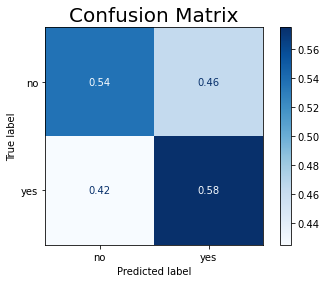

In [ ]:
best_rand_model = best_model.best_estimator_
plot_confusion_matrix(best_rand_model, X_val, y_val, display_labels = le.inverse_transform([0, 1]),
                                 cmap = plt.cm.Blues, normalize = 'true')
plt.title("Confusion Matrix", fontsize = 20);

From the confusion matrix we see that our model predicts correctly just over half of the time when an audio file contains a digit that is divisible by 5 and it also predicts just over half of the time when an audio file contains a digit that isn't divisible by 5 (i.e. out of all the audio files that contain a digit that is divisible by 5 the model predicts only classifies 58% of them as divisible by 5).

Here we plot an ROC curve with its AUC value.

Reference of implementation for the code cell below: https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb

Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.566


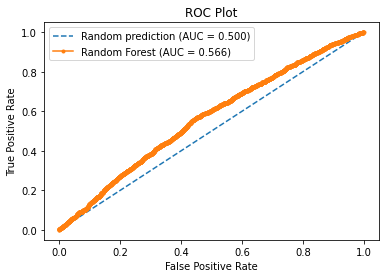

In [ ]:
r_probs = [0 for _ in range(len(y_val))]
rf_probs = best_rand_model.predict_proba(X_val)
rf_probs = rf_probs[:, 1]
# computing the auc for both y = x and the model
r_auc = roc_auc_score(y_val, r_probs)
rf_auc = roc_auc_score(y_val, rf_probs)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
# plotting the curve by using FPR and TPR
r_fpr, r_tpr, _ = roc_curve(y_val, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Note:**

* The True Positive Rate (TPR or recall) is defined as the digit being labelled as divisible by 5 (i.e. "yes") and the model predicting the digit as divisible by 5.
* The False Positive Rate (FPR or 1 - specificity) is defined as the digit being labelled as not divisible by 5 (i.e. "no") and the model predicting the digit as divisible by 5.

From the ROC plot, we can see that our model does slightly better than random guessing. We can also say that the model barely learned anything as the area under the cover (AUC) for our model is 56.6% which is just over 50%.

We will now produce a classification report in order to summarize the results that we have obtained above.

In [ ]:
print(classification_report(y_val, best_model.predict(X_val), target_names = le.inverse_transform([0, 1])))

              precision    recall  f1-score   support

          no       0.56      0.54      0.55      2993
         yes       0.56      0.58      0.57      3007

    accuracy                           0.56      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.56      0.56      0.56      6000



From the classification report the values in the recall column for each class (i.e. "no" and "yes") is the same values as those in the diagonal entries in the confusion matrix. 

## Conclusion

To conclude the accuracy score (55.6%) that we obtained for our best model (random forest classifier) was moderately okay but could have been improved. For future work, in order to get a better accuracy score, we could have extracted more features from the audio files instead of extracting only 4. Due to time constraints, we could also have used grid search (even though it is more computationally expensive than random search) instead of random search so that we could have obtained the best hyperparameters for our best model. Also for our neural network, we also could have used grid search with the same idea in mind in order to make a fairer comparison of the validation accuracy between models. Additionally, we could also have used "dropout" in our neural network in order for the neural network to not rely on specific patterns and to be able to generalise better. Regarding the other models we used in this notebook, we could have also increased the number of K-folds when carrying out cross-validation (which also is more computationally expensive). Finally, we could have also considered algorithms such as SVM (support vector machine) and Naive Bayes classifier as well as using techniques such as gradient boosting to improve the performance of the random forest classifier.